In [11]:
#Librerias que se utilizaran
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import duckdb
import glob
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import euclidean_distances
import datetime
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error


# Librerias astrofisica
# =============================================================================
from astroquery.mast import Observations
import lightkurve as lk
from astropy.time import Time

con = duckdb.connect(database=':memory:')


## Conteo de estrellas por clase

In [12]:
Carac_Stars = pd.read_csv('Carac_Stars.csv')
Carac_Stars

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
0,10797460,0.136,CANDIDATE,1.000
1,10811496,-0.127,FALSE POSITIVE,0.000
2,10848459,-0.522,FALSE POSITIVE,0.000
3,10854555,0.081,CANDIDATE,1.000
4,10872983,-0.067,CANDIDATE,0.992
...,...,...,...,...
7677,10128825,-0.046,CANDIDATE,0.497
7678,10147276,-0.038,FALSE POSITIVE,0.021
7679,10156110,0.082,FALSE POSITIVE,0.000
7680,8460634,-0.556,FALSE POSITIVE,0.000


In [4]:
Carac_Stars[Carac_Stars['Kepler_ID']==10004515]

,Kepler_ID,Metalicidad,Clasificacion,incert_clas
4962,10004515,-0.511,FALSE POSITIVE,NaN


In [5]:
con.execute("""select Clasificacion, count(*)
               from Carac_Stars
               group by Clasificacion""").df()

,Clasificacion,count_star()
0,CANDIDATE,3246
1,FALSE POSITIVE,4436


## Descripción de las series de tiempo

### Registros en el tiempo

In [4]:
url_lc = "../Curvas_de_luz/"

In [13]:
#Ver una curva de luz
arch = os.listdir(url_lc) #arch es un arreglo de todos los csv 
serie = pd.read_csv(url_lc+arch[4]) #serie es el contenido del archivo url_lc+arch[4]
serie

,time,flux,flux_err
0,1559.225851,NaN,NaN
1,1559.246285,5722.0380,3.410506
2,1559.266720,5715.9890,3.413942
3,1559.287154,5720.7886,3.413192
4,1559.307588,5715.8990,3.411039
...,...,...,...
1281,1590.919425,5701.9210,3.389691
1282,1590.939860,5724.5815,3.394305
1283,1590.960294,5731.6890,3.392727
1284,1590.980729,5731.4766,3.398011


In [14]:
#Los datos se encuentran en bkjd (Barycentric Kepler Julian Date)
time = Time(serie['time'], format='bkjd')  # Crear un objeto Time de astropy
datetime_time = time.datetime  # Convertir a datetime
help(datetime_time[0])

Help on datetime object:

class datetime(date)
 |  datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]])
 |  
 |  The year, month and day arguments are required. tzinfo may be None, or an
 |  instance of a tzinfo subclass. The remaining arguments may be ints.
 |  
 |  Method resolution order:
 |      datetime
 |      date
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __hash__(self, /)
 |      Return hash(self).
 |  
 |  __le__(self, value, /)
 |      Return self<=value.
 |  
 |  __lt__(self, value, /)
 |      Return self<value.
 |  
 |  __ne__(self, value, /)
 |      Return self!=value.
 |  
 |  __radd__(self, value, /)
 |      Retur

In [17]:
datetime_time[0]

datetime.datetime(2013, 4, 9, 17, 25, 13, 565184)

In [13]:
# Directorio de curvas de luz con fecha en formato gregoriano
url_lcc = "../Curvas_de_luz_arregladas/"

In [16]:
arch = os.listdir(url_lc)

for star_lc in arch:
    #Se pasa la curva de luz a un dataframe de pandas
    serie = pd.read_csv(url_lc+star_lc)
    
    #Se elimina la primera fila con valores NA
    serie = serie.dropna()
    
    #Se transforman los tiempos a datatime
    time = Time(serie['time'], format='bkjd') #Time retorna un objeto time para el cual esta definida la funcion .datatime. Lib Astrophy
    serie['time'] = time.datetime 
    
    #Guardo la serie arreglada
    serie.to_csv(f'{url_lcc}{star_lc}', index=False) #index=False es para no contar los datos con 1, 2, 3.. por fila

## Descripción de las curvas de luz

In [15]:
#Ver una curva de luz
arch_cor = os.listdir(url_lcc)
summary_series = [] 
num_series = len(arch_cor) #length de arch_cor, el número de curvas

for i in range(num_series):
    # Importación de cada curva de luz
    serie_cor = pd.read_csv(url_lcc+arch_cor[i])
    
    # Extraer longitud de la curva, shape[0] es número de filas, shape[1] es número de columnas
    num_datos = serie_cor.shape[0]
    
    # Extraer la primera y última fecha y hora para las cuales se tiene info en cada curva, 
    summary_series.append([arch_cor[i][3:-4], num_datos, serie_cor['time'][0], serie_cor['time'][num_datos-1]])
   
    # Avance del for
    print(np.round(i*100/num_series, 2))


0.0
0.01
0.03
0.04
0.05
0.07
0.08
0.09
0.1
0.12
0.13
0.14
0.16
0.17
0.18
0.2
0.21
0.22
0.23
0.25
0.26
0.27
0.29
0.3
0.31
0.33
0.34
0.35
0.36
0.38
0.39
0.4
0.42
0.43
0.44
0.46
0.47
0.48
0.49
0.51
0.52
0.53
0.55
0.56
0.57
0.59
0.6
0.61
0.62
0.64
0.65
0.66
0.68
0.69
0.7
0.72
0.73
0.74
0.76
0.77
0.78
0.79
0.81
0.82
0.83
0.85
0.86
0.87
0.89
0.9
0.91
0.92
0.94
0.95
0.96
0.98
0.99
1.0
1.02
1.03
1.04
1.05
1.07
1.08
1.09
1.11
1.12
1.13
1.15
1.16
1.17
1.18
1.2
1.21
1.22
1.24
1.25
1.26
1.28
1.29
1.3
1.31
1.33
1.34
1.35
1.37
1.38
1.39
1.41
1.42
1.43
1.44
1.46
1.47
1.48
1.5
1.51
1.52
1.54
1.55
1.56
1.58
1.59
1.6
1.61
1.63
1.64
1.65
1.67
1.68
1.69
1.71
1.72
1.73
1.74
1.76
1.77
1.78
1.8
1.81
1.82
1.84
1.85
1.86
1.87
1.89
1.9
1.91
1.93
1.94
1.95
1.97
1.98
1.99
2.0
2.02
2.03
2.04
2.06
2.07
2.08
2.1
2.11
2.12
2.13
2.15
2.16
2.17
2.19
2.2
2.21
2.23
2.24
2.25
2.27
2.28
2.29
2.3
2.32
2.33
2.34
2.36
2.37
2.38
2.4
2.41
2.42
2.43
2.45
2.46
2.47
2.49
2.5
2.51
2.53
2.54
2.55
2.56
2.58
2.59
2.6
2.62
2.63
2.64
2.

In [7]:
summary_series = np.array(summary_series)

df_summary_series = pd.DataFrame()
df_summary_series["ID"] = summary_series[:,0]
df_summary_series["Long"] = summary_series[:,1].astype(np.float64)
df_summary_series["Fecha_inicio"] = summary_series[:,2]
df_summary_series["Fecha_final"] = summary_series[:,3]

df_summary_series.to_csv("Curve_Statistics", index=False)
df_summary_series

NameError: name 'summary_series' is not defined

In [9]:
print(f'Número mínimo de observaciones temporales: ', np.min(df_summary_series["Long"]))
print(f'Número máximo de observaciones temporales: ', np.max(df_summary_series["Long"]))
print(f'Número promedio de observaciones temporales: ', round(np.mean(df_summary_series["Long"]),2))
print(f'Desviación estándar del número de observaciones temporales: ', round(np.sqrt(np.var(df_summary_series["Long"])),2))
print(f'Los topes superior e inferior que se pueden considerar para filtrar el conjunto de curvas según su número de observaciones son respectivamente:\n', round(np.mean(df_summary_series["Long"]),2)+round(np.sqrt(np.var(df_summary_series["Long"])),2), "\n", round(np.mean(df_summary_series["Long"]),2)-round(np.sqrt(np.var(df_summary_series["Long"])),2))

NameError: name 'df_summary_series' is not defined

In [67]:
df_summary_final = df_summary_series[(df_summary_series["Long"]<=75000) & (df_summary_series["Long"]>=50000)] 
# filtrar curvas en aquellas cuyos elementos de Long sean <=75000 y mayores a 50000

In [68]:
print(f'Al filtrar las curvas de luz por su longitud se abarca el ', round(df_summary_final.shape[0]*100/df_summary_series.shape[0],2), '%') 
#round(number, n) redondea los decimales hasta n

Al filtrar las curvas de luz por su longitud se abarca el  87.4 %


Como no se reduce mucho el número de curvas al restringir la longitud de las curvas, se van a escoger aquellas que no tengan menos de 50.000 y más de 75.000 obervaciones.
Utilizando como método para igualar las longitudes de lass curvas la **interpolación lineal**, esto para mantener las tendencias temporales

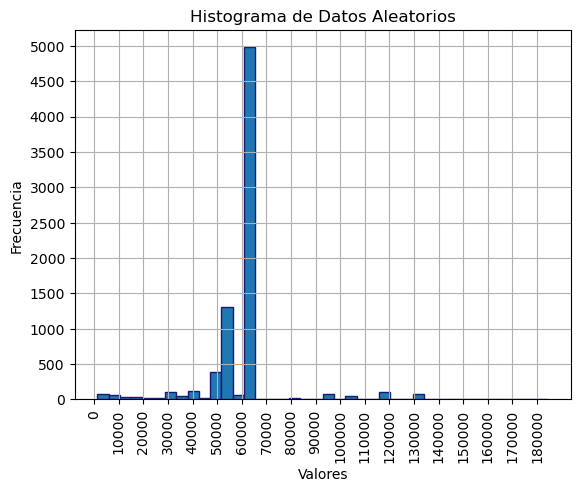

In [88]:
# Histograma
plt.grid(True)
plt.hist(df_summary_series["Long"], bins=40, edgecolor='midnightblue')  # Puedes ajustar el número de bins según sea necesario
plt.xticks(np.arange(0, np.max(df_summary_series["Long"]), 10000), rotation=90)  # Graduación en el eje x de -4 a 4 con incrementos de 1
plt.yticks(np.arange(0, 5500, 500))  # Graduación en el eje y de 0 a 200 con incrementos de 20
plt.title('Histograma de Datos Aleatorios')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

## Interpolación de datos

In [96]:
serie_p = pd.read_csv(url_lcc+"LC_"+df_summary_final["ID"][5]+".csv")
serie_p["time"] = pd.to_datetime(serie_p['time'])
serie_p

,time,flux,flux_err
0,2009-05-13 00:17:48.074450,-0.675724,4.378337
1,2009-05-13 00:47:13.607435,-0.590605,4.378040
2,2009-05-13 01:16:39.131780,-0.592907,4.376898
3,2009-05-13 01:46:04.647475,-0.654469,4.376381
4,2009-05-13 02:15:30.171800,-0.591685,4.378915
...,...,...,...
64786,2013-05-11 10:04:33.885863,-0.583065,4.457614
64787,2013-05-11 10:33:59.420739,-0.465414,4.456690
64788,2013-05-11 11:03:24.946976,-0.366041,4.458636
64789,2013-05-11 11:32:50.464576,-0.307354,4.453619


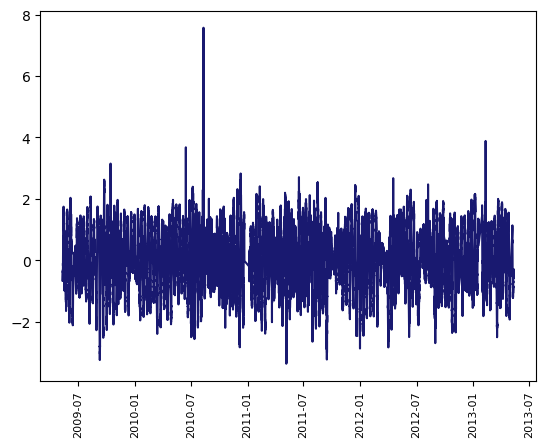

In [101]:
plt.plot(serie_p["time"], serie_p["flux"], color="midnightblue")
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [122]:
n = serie_p.shape[0]
dates = np.zeros(n, dtype='datetime64[D]')
for i in range(n):
    dates[i] = serie_p["time"][i].date() #date extrae solo la fecha de el datetime

serie_p["date"] = dates #agrega una columna con fechas sin horas
frec_dias = pd.crosstab(index=serie_p["date"],columns="frecuencia") 
min_k = round(np.mean(frec_dias)) # número promedio de observaciones de un dia
max_k = 7*min_k # número promedio de observaciones en una semana
#time_series_df = serie_p.set_index('time')

47
329


In [148]:
n_est = 75000-n
np.random.seed(1312) #np.random es un objeto generador de numeros aleatorios
random_n = np.random.choice(np.arange(1, n), n_est, replace=False) #crea un array de numpy con n_est numerros aleatorios entre 1 y n(posiciones)
dates_interp =  np.zeros(n_est, dtype='datetime64[s]') #array de fechas zeros

#determinas las fechas de las posiciones aleatorias
for d in range(len(random_n)):
    i = random_n[d]
    dif_dates = serie_p["time"][i] - serie_p["time"][i-1] 
    dates_interp[d] = serie_p["time"][i-1] + dif_dates/2

#creación del dataframe con las fechas y el resto de variables con NaN
serie_interp = pd.DataFrame() 
serie_interp["time"] = dates_interp 
serie_interp["flux"] = [np.nan]*n_est
serie_interp["flux_err"] = [np.nan] * n_est

#se agrega una columna de fechas sin hora
dates2 = np.zeros(n_est, dtype='datetime64[D]')
for i in range(n_est):
    dates2[i] = serie_interp["time"][i].date()
serie_interp["date"] = dates2

#se concatenan los dataframes, se ordenan por "time" y despues resetean los indices
serie_full = pd.concat([serie_p, serie_interp])
serie_full = serie_full.sort_values(by='time').reset_index(drop=True).drop(columns=['flux_err','date'])

In [149]:
serie_full = serie_full.set_index('time')
serie_full

,flux
time,
2009-05-13 00:17:48.074450,-0.675724
2009-05-13 00:32:30.000000,NaN
2009-05-13 00:47:13.607435,-0.590605
2009-05-13 01:16:39.131780,-0.592907
2009-05-13 01:46:04.647475,-0.654469
...,...
2013-05-11 10:04:33.885863,-0.583065
2013-05-11 10:33:59.420739,-0.465414
2013-05-11 11:03:24.946976,-0.366041


In [41]:
distancias = np.array([[10,143,132,37,20],[135,735,146, 1157,20]])
np.argsort(distancias)

array([[0, 4, 3, 2, 1],
       [4, 0, 2, 1, 3]])

In [42]:
euclidean_distances(distancias)

array([[   0.        , 1273.06127111],
       [1273.06127111,    0.        ]])

In [ ]:
def weighted_knn_impute(X, n_neighbors=5):
    # Crear una máscara para identificar los valores faltantes
    mask = np.isnan(X)
    
    # Crear una copia del array para no modificar el original
    X_imputed = X.copy()
    
    # Calcular las distancias entre todas las muestras
    distances = euclidean_distances(X)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if mask[i, j]:  # Si el valor es faltante
                # Ordenar las distancias y obtener los índices de los K vecinos más cercanos
                neighbor_indices = np.argsort(distances[i])[1:n_neighbors+1]
                
                # Obtener los valores de los vecinos para la característica j
                neighbor_values = X[neighbor_indices, j]
                
                # Filtrar los vecinos que no tienen valores faltantes en la característica j
                valid_neighbors = neighbor_values[~np.isnan(neighbor_values)]
                
                if len(valid_neighbors) > 0:
                    # Calcular las distancias de los vecinos válidos
                    valid_distances = distances[i, neighbor_indices][~np.isnan(neighbor_values)]
                    
                    # Calcular el promedio ponderado
                    weights = 1 / valid_distances
                    weighted_average = np.sum(valid_neighbors * weights) / np.sum(weights)
                    
                    # Imputar el valor
                    X_imputed[i, j] = weighted_average
    
    return X_imputed

# Ejemplo de uso
data = np.array([[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [7, 8, 9]])
imputed_data = weighted_knn_impute(data, n_neighbors=3)
print(imputed_data)

In [153]:
# Aplicar el mejor valor de k a toda la serie de tiempo
imputer = KNNImputer(n_neighbors=min_k) # Imputer es un objeto para interpolar
values = serie_full[['flux']] 
interpolated_values = imputer.fit_transform(values) #Imputer fit_transform interpola los NaN

# Convertir los resultados de nuevo a un DataFrame
#interpolated_df = pd.DataFrame(interpolated_values, index=serie_full['time'], columns=['flux'])

KeyError: 'time'

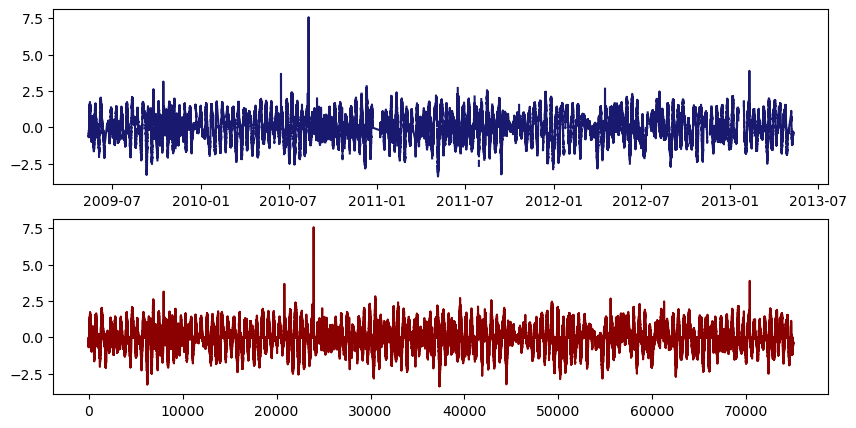

In [164]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(serie_full['flux'], color='midnightblue')
plt.subplot(2,1,2)
plt.plot(interpolated_values, color='darkred')
plt.show()